### Try running this script on Google Colab / Kaggle / Ada (if you have access)
### This might take time if you run it on your local machine

<hr>

# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Setting seed to ensure that results are reproducible
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

# Using GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

<hr>

## Data preparation

In [2]:
mnist_train = datasets.MNIST(root='data', train=True,  transform=transforms.ToTensor(), download=True)
mnist_test  = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

<hr>

## LeNet on MNIST

### Data preparation and loader

In [3]:
class MNISTDataLoaders():
    def __init__(self, batch_size=64, train_subset_size=None):
        self.transform    = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

        self.train_data   = datasets.MNIST(root='data', train=True,  transform=self.transform, download=True)
        self.test_data    = datasets.MNIST(root='data', train=False, transform=self.transform, download=True)

        if train_subset_size is None or train_subset_size == len(self.train_data):
            # Full dataset

            self.train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)

        else:
            # Subset of train split - Have to sample data such that each class has equal number of samples
            # Hence using stratify

            data_indices      = np.arange(len(self.train_data))
            train_indices, _  = train_test_split(data_indices, train_size=train_subset_size, stratify=self.train_data.targets.numpy())

            self.train_data   = torch.utils.data.Subset(self.train_data, train_indices)
            self.train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)

        self.test_loader  = torch.utils.data.DataLoader(self.test_data,  batch_size=batch_size, shuffle=False)

<hr>

### Model architecture

In [4]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1   = nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=5)
        self.conv2   = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1     = nn.Linear(in_features=16*4*4, out_features=120)
        self.fc2     = nn.Linear(in_features=120,    out_features=84)
        self.fc3     = nn.Linear(in_features=84,     out_features=10)

        self.pool    = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu    = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pytorch has convention (batch_size, channels, height, width)
        x = x.view(-1, 1, 28, 28)

        x = self.conv1(x) # x -> 24x24x6
        x = self.pool(x)  # x -> 12x12x6
        x = self.relu(x)

        x = self.conv2(x) # x -> 8x8x16
        x = self.pool(x)  # x -> 4x4x16
        x = self.relu(x)

        x = x.view(-1, 16*4*4) # x -> 1024 (Flattened to pass through fully connected layers)

        x = self.fc1(x) # x -> 120
        x = self.relu(x)

        x = self.fc2(x) # x -> 84
        x = self.relu(x)

        x = self.fc3(x) # x -> 10 - As there are 10 digits
        x = self.softmax(x) # For probabilities

        return x

<hr>

### Trainer

In [5]:
class Trainer():
    def __init__(self, model, train_loader, test_loader, optimizer, criterion=nn.CrossEntropyLoss()):
        self.model        = model
        self.train_loader = train_loader
        self.test_loader  = test_loader
        self.optimizer    = optimizer
        self.criterion    = criterion

    def train_epoch(self, epochs=10):
        for epoch in range(epochs):
            self.model.train()

            train_loss = 0.0
            train_acc  = 0.0

            train_progress_bar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
            for batch_idx, (data, target) in train_progress_bar:
                data, target = data.to(device), target.to(device)

                self.optimizer.zero_grad()

                output = self.model(data)

                batch_loss  = self.criterion(output, target)
                train_loss += batch_loss.mean().item()
                batch_loss.backward()

                pred         = output.argmax(dim=1)
                train_acc  += (pred == target).sum().item() / len(target)

                self.optimizer.step()

                train_progress_bar.set_description(f'Epoch {epoch+1}/{epochs}: Train epoch')
                train_progress_bar.set_postfix(Loss=train_loss/(batch_idx+1), Accuracy=train_acc/(batch_idx+1))

            self.test_epoch(epoch, epochs)

            print()

        return train_acc / len(self.train_loader), train_loss / len(self.train_loader)

    def test_epoch(self, epoch=None, epochs=None):
        self.model.eval()

        test_loss = 0
        test_acc  = 0

        with torch.no_grad():
            test_progress_bar = tqdm(enumerate(self.test_loader), total=len(self.test_loader))
            for batch_idx, (data, target) in test_progress_bar:
                data, target = data.to(device), target.to(device)
                output = self.model(data)

                test_loss += self.criterion(output, target).mean().item()

                pred       = output.argmax(dim=1)
                test_acc  += (pred == target).sum().item() / len(target)

                if epoch is not None and epochs is not None:
                    test_progress_bar.set_description(f'Epoch {epoch+1}/{epochs}: Test epoch ')
                    test_progress_bar.set_postfix(Loss=test_loss/(batch_idx+1), Accuracy=test_acc/(batch_idx+1))
                else:
                    test_progress_bar.set_postfix(Loss=test_loss/(batch_idx+1), Accuracy=test_acc/(batch_idx+1))

        return test_acc / len(self.test_loader), test_loss / len(self.test_loader)

    def predict(self, data):
        self.model.eval()

        with torch.no_grad():
            output = self.model(data)
            pred   = output.argmax(dim=1)

        return pred

<hr>

In [6]:
data_loaders = MNISTDataLoaders()
train_loader = data_loaders.train_loader
test_loader  = data_loaders.test_loader

model        = LeNet().to(device)

optimizer    = optim.Adam(model.parameters(), lr=0.001)

trainer      = Trainer(model, train_loader, test_loader, optimizer)

trainer.train_epoch(epochs=5)

Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 63.94it/s, Accuracy=0.969, Loss=1.49]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.51it/s, Accuracy=0.973, Loss=1.49]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 59.64it/s, Accuracy=0.98, Loss=1.48] 


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.49it/s, Accuracy=0.98, Loss=1.48] 


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.46it/s, Accuracy=0.982, Loss=1.48]


(0.9818430170575693, 1.479707878789922)

<hr>

## Hyperparameter tuning on batch size, learning rate and optimizer

In [7]:
configs = [
    {'batch_size': 64, 'lr': 0.001,  'optimizer': 'Adam'},
    {'batch_size': 32, 'lr': 0.001,  'optimizer': 'Adam'},
    {'batch_size': 64, 'lr': 0.0001, 'optimizer': 'Adam'},
    {'batch_size': 64, 'lr': 0.001,  'optimizer': 'SGD'},
    {'batch_size': 32, 'lr': 0.001,  'optimizer': 'SGD'},
    {'batch_size': 64, 'lr': 0.0001, 'optimizer': 'SGD'}
]

max_accuracy = 0
accuracies   = []
best_config  = None

for config in configs:
    data_loaders = MNISTDataLoaders(batch_size=config['batch_size'])
    train_loader = data_loaders.train_loader
    test_loader  = data_loaders.test_loader

    model        = LeNet().to(device)

    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['lr'])

    trainer      = Trainer(model, train_loader, test_loader, optimizer)

    print(f"Training model with batch_size={config['batch_size']}, lr={config['lr']} and {config['optimizer']} optimizer...")
    trainer.train_epoch(epochs=5)

    print("Evaluation on test set...")
    accuracy, _  = trainer.test_epoch()

    accuracies.append(accuracy)

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_config  = config

    print("====================================================")
    print()

Training model with batch_size=64, lr=0.001 and Adam optimizer...


Epoch 1/5: Train epoch:   0%|          | 0/938 [00:00<?, ?it/s, Accuracy=0.0469, Loss=2.3]

Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 64.43it/s, Accuracy=0.879, Loss=1.58]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 63.23it/s, Accuracy=0.973, Loss=1.49]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 70.57it/s, Accuracy=0.981, Loss=1.48]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 70.66it/s, Accuracy=0.985, Loss=1.48]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.52it/s, Accuracy=0.979, Loss=1.48]



Evaluation on test set...


100%|██████████| 157/157 [00:02<00:00, 69.25it/s, Accuracy=0.979, Loss=1.48]



Training model with batch_size=32, lr=0.001 and Adam optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 94.56it/s, Accuracy=0.963, Loss=1.5] 


Epoch 2/5: Test epoch : 100%|██████████| 313/313 [00:02<00:00, 106.66it/s, Accuracy=0.972, Loss=1.49]


Epoch 3/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 100.09it/s, Accuracy=0.981, Loss=1.48]


Epoch 4/5: Test epoch : 100%|██████████| 313/313 [00:02<00:00, 107.24it/s, Accuracy=0.977, Loss=1.48]


Epoch 5/5: Test epoch : 100%|██████████| 313/313 [00:02<00:00, 119.52it/s, Accuracy=0.985, Loss=1.48]



Evaluation on test set...


100%|██████████| 313/313 [00:02<00:00, 123.21it/s, Accuracy=0.985, Loss=1.48]



Training model with batch_size=64, lr=0.0001 and Adam optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.69it/s, Accuracy=0.751, Loss=1.72]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 63.02it/s, Accuracy=0.77, Loss=1.69] 


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.26it/s, Accuracy=0.777, Loss=1.68]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 64.34it/s, Accuracy=0.779, Loss=1.68]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 70.58it/s, Accuracy=0.782, Loss=1.68]



Evaluation on test set...


100%|██████████| 157/157 [00:02<00:00, 69.82it/s, Accuracy=0.782, Loss=1.68]



Training model with batch_size=64, lr=0.001 and SGD optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.29it/s, Accuracy=0.119, Loss=2.3]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 63.97it/s, Accuracy=0.14, Loss=2.3] 


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.16it/s, Accuracy=0.161, Loss=2.3]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 63.02it/s, Accuracy=0.179, Loss=2.3]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.67it/s, Accuracy=0.187, Loss=2.3]



Evaluation on test set...


100%|██████████| 157/157 [00:02<00:00, 69.58it/s, Accuracy=0.187, Loss=2.3]



Training model with batch_size=32, lr=0.001 and SGD optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 98.01it/s, Accuracy=0.103, Loss=2.3]  


Epoch 2/5: Test epoch : 100%|██████████| 313/313 [00:02<00:00, 119.12it/s, Accuracy=0.105, Loss=2.3] 


Epoch 3/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 99.79it/s, Accuracy=0.111, Loss=2.3] 


Epoch 4/5: Test epoch : 100%|██████████| 313/313 [00:02<00:00, 105.79it/s, Accuracy=0.124, Loss=2.3]


Epoch 5/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 100.12it/s, Accuracy=0.146, Loss=2.3]



Evaluation on test set...


100%|██████████| 313/313 [00:02<00:00, 130.66it/s, Accuracy=0.146, Loss=2.3]



Training model with batch_size=64, lr=0.0001 and SGD optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.87it/s, Accuracy=0.1, Loss=2.3]   


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.13it/s, Accuracy=0.101, Loss=2.3]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 63.71it/s, Accuracy=0.101, Loss=2.3]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.71it/s, Accuracy=0.101, Loss=2.3]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.80it/s, Accuracy=0.101, Loss=2.3]



Evaluation on test set...


100%|██████████| 157/157 [00:02<00:00, 67.55it/s, Accuracy=0.101, Loss=2.3]

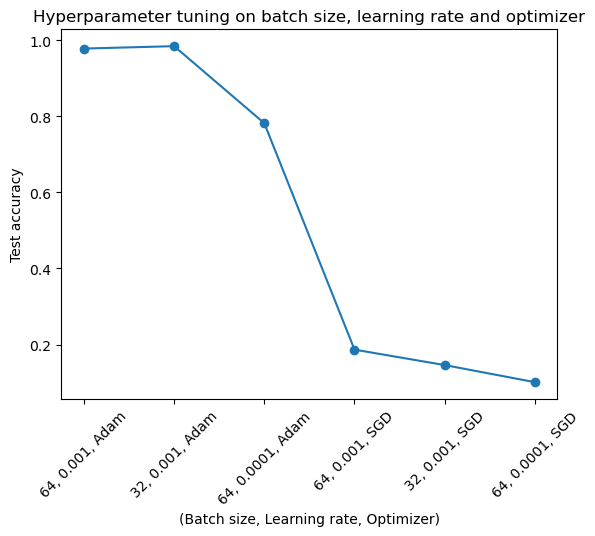

In [8]:
plt.plot(  [f'{config["batch_size"]}, {config["lr"]}, {config["optimizer"]}' for config in configs], accuracies, marker='o')
plt.xticks([f'{config["batch_size"]}, {config["lr"]}, {config["optimizer"]}' for config in configs], rotation=45)
plt.xlabel('(Batch size, Learning rate, Optimizer)')
plt.ylabel('Test accuracy')
plt.title('Hyperparameter tuning on batch size, learning rate and optimizer')
plt.show()

- ### As we can see the Adam optimizer greatly outperforms the SGD optimiser in terms of accuracy
- ### The next thing we can notice is the impact of learning rate: A lesser learning rate of 1e-4 converges slower and has worse performance as compared to a higher learning rate of 1e-3
- ### The batch size does not have a significant impact on the performance of the model
- ### Hence, we can deduce that the optimizer and the learning rate are the most important hyperparameters to tune

- ### The best configuration for the LeNet model is:
    - ### Optimizer = Adam
    - ### Learning rate = 1e-3
    - ### Batch size = 32

<hr>

## Doubling number of convolutional layers in LeNet

In [9]:
class DoubleLeNet(nn.Module):
    def __init__(self):
        super(DoubleLeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=6,  kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6,  out_channels=16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)

        self.fc1   = nn.Linear(in_features=64*3*3, out_features=120)
        self.fc2   = nn.Linear(in_features=120,    out_features=84)
        self.fc3   = nn.Linear(in_features=84,     out_features=10)

        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu    = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pytorch has convention (batch_size, channels, height, width)
        x = x.view(-1, 1, 28, 28)

        x = self.conv1(x) # x -> 28x28x6
        x = self.pool(x)  # x -> 14x14x6
        x = self.relu(x)

        x = self.conv2(x) # x -> 14x14x16
        x = self.pool(x)  # x -> 7x7x16
        x = self.relu(x)

        x = self.conv3(x) # x -> 9x9x32
        x = self.pool(x)  # x -> 4x4x32

        x = self.conv4(x) # x -> 6x6x64
        x = self.pool(x)  # x -> 3x3x64
        x = self.relu(x)

        x = x.view(-1, 64*3*3) # x -> 576 (Flattened to pass through fully connected layers)

        x = self.fc1(x) # x -> 120
        x = self.relu(x)

        x = self.fc2(x) # x -> 84
        x = self.relu(x)

        x = self.fc3(x) # x -> 10
        x = self.softmax(x) # For probabilities

        return x

double_data_loaders = MNISTDataLoaders()
double_train_loader = double_data_loaders.train_loader
double_test_loader  = double_data_loaders.test_loader

double_model        = DoubleLeNet().to(device)

double_optimizer    = optim.Adam(double_model.parameters(), lr=0.001)

double_trainer      = Trainer(double_model, double_train_loader, double_test_loader, double_optimizer)

double_trainer.train_epoch(epochs=5)

Epoch 1/5: Train epoch:   0%|          | 0/938 [00:00<?, ?it/s, Accuracy=0.105, Loss=2.3] 

Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.26it/s, Accuracy=0.967, Loss=1.5] 


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 69.26it/s, Accuracy=0.97, Loss=1.49] 


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 69.18it/s, Accuracy=0.979, Loss=1.48]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 59.43it/s, Accuracy=0.974, Loss=1.49]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.30it/s, Accuracy=0.977, Loss=1.48]


(0.9753131663113006, 1.485776006285824)

- ### As we can see from the above run, the performance has not changed much inspite of doubling the number of convolutional layers
- ### Some changes to the architecture had to be made - in terms of kernel size and padding to keep the feature maps large enough by the time they reach the last layer

- ### This can be explained by the fact that the relations present in the data can be learnt by the normal LeNet model and more complexity does not help in providing additional information
- ### We can also see that the performance is slightly lesser as compared to the normal LeBNet model and this might be an indication of possible overfitting

<hr>

## Accuracy v/s Number of training samples

In [10]:
train_dataset_sizes = [600, 1800, 6000, 18000, 60000]
accuracies          = []

for train_dataset_size in train_dataset_sizes:
    print(f"Training with {train_dataset_size} samples...")

    batch_size   = 32 if train_dataset_size < 10000 else 64
    data_loaders = MNISTDataLoaders(batch_size=batch_size, train_subset_size=train_dataset_size)
    train_loader = data_loaders.train_loader
    test_loader  = data_loaders.test_loader

    model        = LeNet().to(device)

    optimizer    = optim.Adam(model.parameters(), lr=0.001)

    trainer      = Trainer(model, train_loader, test_loader, optimizer)

    trainer.train_epoch(epochs=5)

    print("Evaluating the model on test set...")
    test_acc, _ = trainer.test_epoch()
    accuracies.append(test_acc)

    print("====================================================")
    print()

Training with 600 samples...


Epoch 1/5: Train epoch:   0%|          | 0/19 [00:00<?, ?it/s, Accuracy=0.125, Loss=2.3]

Epoch 1/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 97.43it/s, Accuracy=0.375, Loss=2.24] 


Epoch 2/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 98.91it/s, Accuracy=0.574, Loss=1.93] 


Epoch 3/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 97.16it/s, Accuracy=0.676, Loss=1.81] 


Epoch 4/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 98.09it/s, Accuracy=0.785, Loss=1.7]  


Epoch 5/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 101.20it/s, Accuracy=0.786, Loss=1.69]



Evaluating the model on test set...


100%|██████████| 313/313 [00:02<00:00, 117.92it/s, Accuracy=0.786, Loss=1.69]



Training with 1800 samples...


Epoch 1/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 102.23it/s, Accuracy=0.586, Loss=1.91]


Epoch 2/5: Test epoch : 100%|██████████| 313/313 [00:02<00:00, 108.31it/s, Accuracy=0.727, Loss=1.74]


Epoch 3/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 101.11it/s, Accuracy=0.782, Loss=1.69]


Epoch 4/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 103.81it/s, Accuracy=0.901, Loss=1.57]


Epoch 5/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 97.22it/s, Accuracy=0.915, Loss=1.56] 



Evaluating the model on test set...


100%|██████████| 313/313 [00:02<00:00, 117.48it/s, Accuracy=0.915, Loss=1.56]



Training with 6000 samples...


Epoch 1/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 99.06it/s, Accuracy=0.8, Loss=1.68]   


Epoch 2/5: Test epoch : 100%|██████████| 313/313 [00:02<00:00, 115.43it/s, Accuracy=0.923, Loss=1.54]


Epoch 3/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 103.23it/s, Accuracy=0.929, Loss=1.54]


Epoch 4/5: Test epoch : 100%|██████████| 313/313 [00:02<00:00, 105.02it/s, Accuracy=0.944, Loss=1.52]


Epoch 5/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 99.32it/s, Accuracy=0.954, Loss=1.51] 



Evaluating the model on test set...


100%|██████████| 313/313 [00:02<00:00, 113.92it/s, Accuracy=0.954, Loss=1.51]



Training with 18000 samples...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.42it/s, Accuracy=0.832, Loss=1.63]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.94it/s, Accuracy=0.94, Loss=1.52] 


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.33it/s, Accuracy=0.96, Loss=1.5]  


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 59.95it/s, Accuracy=0.96, Loss=1.5]  


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 70.48it/s, Accuracy=0.967, Loss=1.5]



Evaluating the model on test set...


100%|██████████| 157/157 [00:02<00:00, 73.54it/s, Accuracy=0.967, Loss=1.5]



Training with 60000 samples...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.83it/s, Accuracy=0.961, Loss=1.5] 


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 67.89it/s, Accuracy=0.972, Loss=1.49]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.69it/s, Accuracy=0.977, Loss=1.48]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.40it/s, Accuracy=0.981, Loss=1.48]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.40it/s, Accuracy=0.984, Loss=1.48]



Evaluating the model on test set...


100%|██████████| 157/157 [00:02<00:00, 68.23it/s, Accuracy=0.984, Loss=1.48]

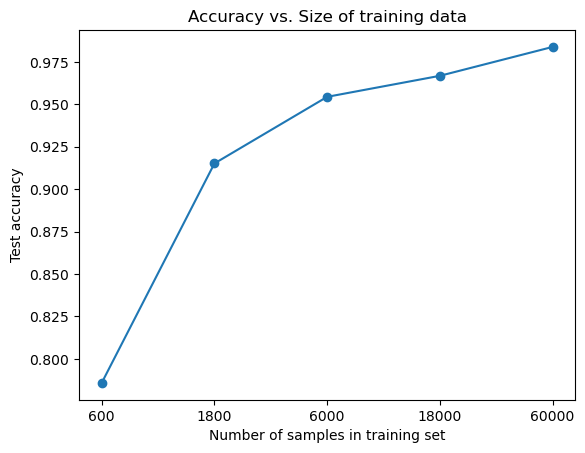

In [11]:
plt.plot([str(size) for size in train_dataset_sizes], accuracies, marker='o')
plt.xlabel('Number of samples in training set')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs. Size of training data')
plt.show()

- ### We can see that intially, the accuracy is fairly low in comparision to the models trained with more data
- ### This is indicative of the necessity of more data for CNNs
- ### But notice that the accuracy jumps by a huge amount with just a small increase in the amount of data
  - ### This can be explained by the fact that due to the uniform distribution of data across all labels, the increase in data is enough for the CNN to capture all the required patterns in the data
- ### An interesting observation is that the model does not benefit much from adding more data after a point - Consider the jump from 6K images to 18K images to 60K images
  - ### Nearly similar performance for one-tenth, two-fifths and full data

<hr>